# Introduction

This notebook is dedicated to the cause of constructing a parameter which combines all intrinsic and orientation parameters of a CBC to describe the amount of observable precession from an overhead source, drawing from the trends observed in $\texttt{Notebook 1}$ of this series. If you haven't played around in $\texttt{Notebook 1}$ yet, I recommend you do that before reading this one. In essence we are defining "observable precession" as equivalent to any loss in Match between a precessing waveform and a non-precessing waveform with the same intrinsic parameters. (Not a perfect assumption - many precession signals will Match better with templates of different intrinsic parameter values, but this approximation is a useful first step.)

- Section 1: Trends in Match for Fixed Masses
- Section 2: Trends in Match for Varying Mass Ratio (Total Mass = 25)
    
We care about 11 parameters in this notebook (reduced to 7 via $\chi_p$ and $\chi_{eff}$): the masses, the spins, and the orientation angles ($\psi$, $\theta_{JN}$, $\phi_{JL}$).

I begin fixing masses to $m_1=20,m_2=5$. Reasons for this are: similar masses to GW151012 so we know such systems exist, and a mass-ratio which allows for plenty of precession. But the notebook's code can explore any mass combination so explore to your heart's content.

Distance to source is relevant for effective volumes which, if we do well finding a function for observable precession, becomes relevant when discerning which signals are likely to be loud enough to be observable. But for this bit, we're only looking at Matches, where amplitude is irrelevant. Distance is dismissed.
We do not care at all about time. Like, maybe later if we start using real LIGO noise curves.
Adding sky location $[lat.,long.]$ is left for further work. In principle sky location simply changes the effective values for the orientation parameters (whilst also limiting the amplitude, but we don't care about that for the same reason we don't care about distance). So sky location could be treated as a function which acts on $\theta_{JN}$, $\phi_{JL}$ and $\psi$ before they're input into the "transforminitialconditions" algorithm. Figuring out what that function is, though, sounds dull and I don't want to do it and you can't make me. Maybe it's already out there - ask around.

Reducing the spin components to $\chi_p$ and $\chi_{eff}$ poses a minor problem when it comes to orbital phase. In the PyCBC algorithms the initial phase is defined by two parameters instead of one: $\phi_{JL},\phi_{12}$. $\phi_{12}$ is the azimuthal angle between the two spins (i.e. the angle between the precessing component of $\bf S_1$ and the precessing component of $\bf S_2$). Thus, $\phi_{12}$ is not just an orientation angle - it affects the spin components of the masses. For sources where both masses have precessing spin components, $\phi_{12}$ affects the direction of $\bf J$. In these cases, both $\phi_{12}$ and $\phi_{JL}$ contribute to the initial orbital phase.

However, the algorithms also take a value for $\phi_{ref}$. This parameter sets the orbital phase at the reference frequency (in this notebook, $f_{ref}$ is always the initial waveform frequency, which has its drawbacks - more on that later). Care is needed - changing $\phi_{ref}$ is equivalent to a change in $\phi_{JL}$ and $\phi_{12}$, since you're changing the reference phase at which those parameters are being set. I.e. a change in $\phi_{ref}$ potentially causes the spin components to change. Keeping $\phi_{ref}$ the same for all waveforms (I choose zero) prevents confusion. The same value of $\chi_p$ causes the same amount of precession regardless of which spin dominates. We shall therefore only deal with sources where the larger black hole dominates precessing spin, rendering $\phi_{12}$ meaningless and redundant because we're only giving one mass precessing spin. All this means that $\phi_{JL}$ is the sole parameter which dictates the orbital phase.

Note that we're barely missing out any waveforms by doing this - we're taking advantage of degeneracies between the parameters. Any change in $\phi_{ref}$ and/or $\phi_{12}$ is equivalent to a change in the spin components and $\phi_{JL}$, and we intend to investigate all ranges and combinations of spin and $\phi_{JL}$ so keeping the former two fixed simply prevents us from analysing identical waveforms. There could be some difference between waveforms of the same $\chi_p$ with different contributions from the spins for certain sources, so we might lose a little coverage there. This is possibly worth investigating later, but for now, we've got plenty of parameter space to be getting along with.

A perfectly behaving "observable precession parameter" would track linearly with the Match, $\mathcal{M}$, between precessing waveforms and equivalent non-precessing waveforms throughout all parameter space. In Section 1 we'll start with a single combination of masses with zero aligned spin, trying to model patterns of Match for that combination of masses for all precessing spins and orientations. We'll then see about generalising that model to aligned spins and mass combinations in the following Sections.

## Import important things

In [1]:
'''The usual numpy stuff'''
%matplotlib inline
import pylab as py
from numpy import *

'''Waveform approximants'''
from pycbc.waveform import get_fd_waveform, get_td_waveform, td_approximants

'''Coordinate transform functions'''
from lalsimulation import SimInspiralTransformPrecessingNewInitialConditions
from lalsimulation import SimInspiralInitialConditionsPrecessingApproxs

'''Matched Filtering functions'''
from pycbc.filter import match, sigmasq

'''PSD'''
from pycbc.psd import aLIGOZeroDetHighPower

'''Some other objects from PyCBC'''
from pycbc.types import FrequencySeries, TimeSeries
import pycbc.psd
from pycbc.types import real_same_precision_as
from pycbc.types import complex_same_precision_as

'''Physical constants'''
from lal import MSUN_SI, G_SI, C_SI

from mpl_toolkits.mplot3d import Axes3D

/Users/awmuir/src/pycbc/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Defining Waveform Strain ($\Delta L/L$, $f_+$, $f_{\times}$)

In [2]:
def my_generate_fplus_fcross(latitude,longitude,polarization):
    f_plus = (- (1.0/2.0) * (1.0 + cos(latitude) * cos(latitude)) 
              * cos (2.0 * longitude) * cos (2.0 * polarization) 
              - cos(latitude) * sin(2.0 * longitude) * sin (2.0 * polarization) )
    
    f_cross= ( (1.0/2.0) * (1.0 + cos(latitude) * cos(latitude)) 
              * cos (2.0 * longitude) * sin (2.0 * polarization) 
              - cos (latitude) * sin(2.0 * longitude) * cos (2.0 * polarization) )
    
    return f_plus, f_cross

def my_generate_detector_strain(h_plus, h_cross, polarization,latitude,longitude):
    f_plus, f_cross = my_generate_fplus_fcross(latitude, longitude, polarization)
    return f_plus * h_plus + f_cross * h_cross

### Define Opening Angle (LAL's cobbled definition)

In [3]:
'''LAL Opening Angle'''
'''PhenomP opening angle'''

def LALbeta(m1,m2,chi_p,spinz1,spinz2,freq):   #Sp = dimensionful perp. spin, SL = dimensionful aligned spin.
    M = m1 + m2
    M_si = M * MSUN_SI
    
    Sp = m1*m1*chi_p/M**2
    SL = (m1*m1*spinz1 + spinz2*m2*m2)/M**2
        
    v = (M_si*pi*freq*G_SI/C_SI**3.)**(1./3.)
    #    v = pow((M*pi*freq*), 1./3.)
    x = v*v
    x2 = x*x
    
    eta = m1*m2 / (m1+m2)**2.
    eta2 = eta*eta
    
    #L0PN = eta/v
    L2PN = (eta*(1.0 + (1.5 + eta/6.0)*x + (3.375 - (19.0*eta)/8. - eta2/24.0)*x2)) / v

    s = Sp / (L2PN + SL)
    s2 = s*s
    cos_beta_lal = pow(sqrt(1.0 + s2), -1)
    cos_beta_half = sqrt( (1.0 + cos_beta_lal) / 2.0 )
    beta_half = arccos(cos_beta_half)
    beta = arccos(cos_beta_lal)
    return beta, beta_half, s2

## Section 1: Modelling Trends for Fixed Precessing Spin ($m_1=20M_{\bigodot}$, $m_2=5_{\bigodot}$, $\chi_{eff}=0$)

In this section, we set the black hole masses to $M_1=20$ and $M_2=5$ (solar masses, here and henceforth), set aligned spin to $\chi_{eff}=0$ and attempt to model the trends we see throughout the three orientation parameters ($\theta_{JN},\phi_{JL},\psi$) for a given value of $\chi_p$.

We set $\phi_{JL}=90$ so the ring of worst Matches is a circle, centred on $[\theta_{JN}=90,\psi=45]$.

The code window below is a cut-and-paste job of the entire "Plot 2" section in Notebook 1.

In [5]:
'''Circle of Badness Plot: Match Calculation'''
'''Give the source masses (in solar masses)'''
mass1 = 20.
mass2 =  5.

if mass2>mass1:     #Mass1 is always bigger. Obey the law.
    tmpmass = mass2
    mass2 = mass1
    mass1 = tmpmass

'''Aligned dimensionless spin for each mass'''
'''(-1 to 1)'''
spin_z1 =  0.            #Spin components aligned with L.
spin_z2 =  spin_z1  #I tend to give both the same aligned spin - it makes controlling chi_eff easier.

'''Precessional spin magnitude for each mass'''
'''(0 to 1)'''
chi_perp1   = 0.6      #DON'T EXCEED MAXIMUM SPIN OR BAD THINGS WILL HAPPEN TO YOU.
chi_perp2   = 0.0     #<<< This one is only interesting if the masses are near identical and you're really bored.

'''Give ranges of psi and thetaJN (degrees)'''
psirange = 21      #Number of different psi values to be matched.
psi_min  =  0     #degrees
psi_max  = 90    #degrees

JNrange     =  41    #Number of different thetaJN values to be matched.
thetaJN_min =   0   #degrees
thetaJN_max = 180  #degrees

'''Give orientation angles (degrees)'''
phi12     =   0.     #phi12 = azimuthal angle between spins.
    #Remember the circle is only central when phiJL is 90, or 270. 
phi_JL    =  90.    #phi_JL = phase of precession of L around J.
phase     =   0.   #Reference phase = PhiRef in SimInspiralTransformPrecessingNewInitialConditions()

'''Give sky location (zero = above detector)'''
latitude  = 0.
longitude = 0.

'''Give distance to source in Mpc'''
dist = 410.

'''Reference frequency, low frequency cut-off and sample rate'''
f_ref   = 30.     #Reference frequency
low_f   = 30.      #Starting frequency
delta_t = 1./2048    #Sample rate


''' [No user input required] '''
''' ------------------------ '''

'''Convert angles to radians'''
psi_min     = radians( psi_min )
psi_max     = radians( psi_max )
thetaJN_min = radians( thetaJN_min )
thetaJN_max = radians( thetaJN_max )
phi12     = radians( phi12 )
phi_JL    = radians( phi_JL )
phase = radians( phase )

'''Create array of polarisations and thetaJNs'''
psi      = linspace(psi_min, psi_max, psirange)
theta_JN = linspace(thetaJN_min, thetaJN_max, JNrange)

'''Define spin magnitudes and inclinations'''
chi1     = sqrt(spin_z1**2 + chi_perp1**2)   #Calculate spin magnitude for each mass.
chi2     = sqrt(spin_z2**2 + chi_perp2**2)
if chi1>1:
    chi1=1.0                        #Prevent Kerr limit being exceeded
    print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."
if chi2>1:
    chi2=1.0
    print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."

if chi1 == 0.: chi1 = 10e-10               #Prevent division by zero.
if chi2 == 0.: chi2 = 10e-10
if spin_z1<0: theta1z = pi               #Gives non-precessing waveform appropriate spin polar angles.
else: theta1z = 0
if spin_z2<0: theta2z = pi
else: theta2z = 0
theta1  = arccos(spin_z1/chi1)       #Calculate polar angle for each mass.
theta2  = arccos(spin_z2/chi2)

'''Calculate chi_eff and chi_p'''
A1 = 1 + 3*mass2/(4*mass1)
A2 = 1 + 3*mass1/(4*mass2)
chi_eff = ( mass1*spin_z1 + mass2*spin_z2 )/(mass1+mass2)

#See Schmidt, Ohme & Hannam (2014): "Towards models of gravitational waves..."
q = mass1/mass2
A1 = 2. + 3.*q/2
A2 = 2. + 3./(2*q)
S1 = chi_perp1*mass1**2
S2 = chi_perp2*mass2**2
top = max(A2*S1,A1*S2)
chi_p = top/(A2*mass1**2)

'''Calculate opening angle'''#                <--------------- Calculate opening angle
lalbeta, halfbeta, s2 = LALbeta(mass1,mass2,chi_p,spin_z1,spin_z2,low_f)

matches = zeros((psirange,JNrange))

'''Set plotting arrays'''
psirangej = complex(0,psirange)
JNrangej  = complex(0,JNrange)
psi_plot,thetajn_plot = mgrid[0:psi_max:psirangej,0:thetaJN_max:JNrangej]

'''CREATE TEMPLATE'''

delta_t = 1./2048

np_inc, np_s1x, np_s1y, np_s1z, np_s2x, np_s2y, np_s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               0., #theta_JN
                                                               phi_JL, #phi_JL
                                                               theta1z, #theta1
                                                               theta2z, #theta2
                                                               phi12, #phi12
                                                               abs(spin_z1), #chi1
                                                               abs(spin_z2), #chi2
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
temp_hplus, temp_hcross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = np_inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = np_s1x,
                        spin1y = np_s1y,
                        spin1z = np_s1z,
                        spin2x = np_s2x,
                        spin2y = np_s2y,
                        spin2z = np_s2z,
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t,
                        f_ref=f_ref)

'''Set psi=0 for this one - it doesnt make a difference anyway'''
temp_vec = my_generate_detector_strain(temp_hplus,temp_hcross, 0, latitude, longitude)
delta_f = 1./ len(temp_vec) / delta_t



'''CREATE SIGNALS AND MATCH TO TEMPLATE'''


for i in range(psirange):  
    for j in range(JNrange):
        #for k in range(JLrange):
            #for l in range(chiprange):
                #for m in range(effrange):
        inc,s1x,s1y,s1z,s2x,s2y,s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               theta_JN[j],
                                                               phi_JL,
                                                               theta1,
                                                               theta2,
                                                               phi12,
                                                               chi1,
                                                               chi2,
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
        splus, scross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = s1x,
                        spin1y = s1y,
                        spin1z = s1z,
                        spin2x = s2x,
                        spin2y = s2y,
                        spin2z = s2z,
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t,
                        f_ref=f_ref)
        
        sig_vec = my_generate_detector_strain(splus,scross, psi[i],latitude,longitude)
        sig_vec.resize(len(temp_vec))
        PSD = aLIGOZeroDetHighPower(len(temp_vec),delta_f,low_f)
        
        matches[i][j], residuals = match(temp_vec,sig_vec,psd=PSD,low_frequency_cutoff=low_f)

### Create Plot

Masses:  20.0 ,  5.0
chi_p:  0.6
chi_eff:  0.0
phiJL:  90.0
phase:  0.0
low_f:  30.0
f_Ref:  30.0
Minimum match:  0.44101087557259844


/Users/awmuir/src/pycbc/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


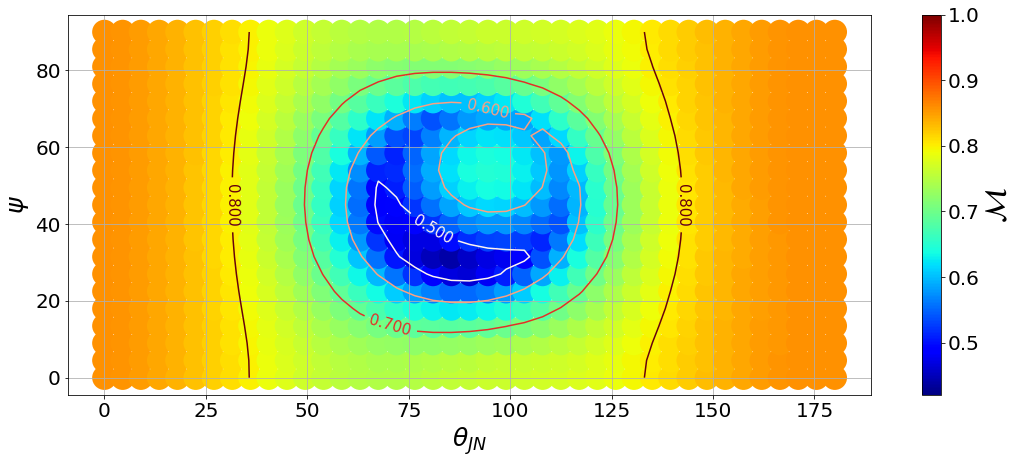

In [6]:
'''Circle of Badness Plotting'''

'''Give plot save filename (saves with the chosen fixed parameters in the title without user interference)'''
nom0 = str(int(mass1)) + "and" + str(int(mass2))
nom1 = str(chi_p)
nom2 = str(int(round(degrees(phi_JL))))
nom4 = str(int(round(degrees(phase))))
nom5 = str(int(round(low_f)))
nom6 = str(chi_eff)
name = "CircleOfBadness_Masses" + nom0 + "_Chip" + nom1[-1] + "_phiJL" + nom2 + "_chieff" + nom6[-1]
    #When using negative chi_eff values, be sure to add this to your filename 
    # + "_lowf" + nom5 # if you're messing with these parameters you may want to add them to filename.

'''Give plot title'''
title = "$\mathcal{M}$ vs $\\theta_{JN}$ vs $\psi$ :  $\phi_{JL}=$" + nom2 + ", $\phi_{ref}=$" + nom4 + " and low_f=" + nom5
    
'''Choose Match contour lines to show (ascending order)'''
lines = [0.5,0.6,0.7,0.8,0.9,0.97] #Leave empty brackets [] for no lines.

'''Choose figure size (scalar) and dot size'''
figsize=[18,7]
dotsize=600

'''Print parameters'''
print "Masses: ", mass1, ", ", mass2
print "chi_p: ", chi_p
print "chi_eff: ", chi_eff
print "phiJL: ", degrees(phi_JL)
print "phase: ", degrees(phase)
print "low_f: ", low_f
print "f_Ref: ", f_ref
print "Minimum match: ", matches.min()

'''Plot Match vs thetaJN vs chi_p'''
py.figure(figsize=figsize)
#py.title(title,fontsize=20)
py.xlabel("$\\theta_{JN}$",fontsize=25)
py.ylabel("$\psi$",fontsize=25)
py.scatter(degrees(thetajn_plot), degrees(psi_plot), c=matches, vmin=.42, vmax=1., s=dotsize, cmap = 'jet', edgecolor='none')
    #Alternatively, max and min colour defined by the matches:
#py.scatter(degrees(thetajn_plot), degrees(psi_plot), c=match2, vmin=match2.min(), vmax=match2.max(), s=dotsize, cmap = 'jet', edgecolor='none')
cbar = py.colorbar()
cbar.set_label(label="$\mathcal{M}$",size=25)
Cont = py.plt.contour(degrees(thetajn_plot), degrees(psi_plot), matches, lines, linewidth=30, cmap = 'Reds')
py.grid(which='both')
py.plt.clabel(Cont, inline=1, fontsize=15)
cbar.set_label(label="$\mathcal{M}$",size=30)
cbar.ax.tick_params(labelsize=20)
py.tick_params(axis='both', which='both', labelsize=20)

#py.savefig(name)
py.show()

### Identifying the Trends

Firstly, increasing $\chi_p$ causes the Matches to get worse across the whole plane. No surprises there. The plot below perhaps demonstrates the trend clearly - it's a 3D plot with several of these $[\theta_{JN},\psi]$ slices at fixed $\chi_p$.

In [20]:
'''3D plot of slices for fixed chi_p'''

'''Circle of Badness Plot: Match Calculation'''
'''Give the source masses (in solar masses)'''
mass1 = 20.
mass2 =  5.

if mass2>mass1:     #Mass1 is always bigger. Obey the law.
    tmpmass = mass2
    mass2 = mass1
    mass1 = tmpmass

'''Aligned dimensionless spin for each mass'''
'''(-1 to 1)'''
spin_z1 =  0.            #Spin components aligned with L.
spin_z2 =  spin_z1  #I tend to give both the same aligned spin - it makes controlling chi_eff easier.

'''Values of chi_p wanted'''
chiprange = 10
chipmin   = 0.     
chipmax   = 0.9

'''Give ranges of psi and thetaJN (degrees)'''
psirange = 31      #Number of different psi values to be matched.
psi_min  =  0.     #degrees
psi_max  = 90.    #degrees

JNrange     =  31    #Number of different thetaJN values to be matched.
thetaJN_min =   0.   #degrees
thetaJN_max = 180.  #degrees

'''Give orientation angles (degrees)'''
phi12     =   0.     #phi12 = azimuthal angle between spins.
    #Remember the circle is only central when phiJL is 90, or 270. 
phi_JL    =  90.    #phi_JL = phase of precession of L around J.
phase     =   0.   #Reference phase = PhiRef in SimInspiralTransformPrecessingNewInitialConditions()

'''Give sky location (zero = above detector)'''
latitude  = 0.
longitude = 0.

'''Give distance to source in Mpc'''
dist = 410.

'''Give sample rate and frequency limits'''
low_f   = 30.      #Starting frequency
delta_t = 1./2048    #Sample rate


''' [No user input required] '''
''' ------------------------ '''

'''Convert angles to radians'''
psi_min     = radians( psi_min )
psi_max     = radians( psi_max )
thetaJN_min = radians( thetaJN_min )
thetaJN_max = radians( thetaJN_max )
phi12     = radians( phi12 )
phi_JL    = radians( phi_JL )
phase = radians( phase )

'''Create array of polarisations, thetaJNs and chi_p'''
psi      = linspace(psi_min, psi_max, psirange)
theta_JN = linspace(thetaJN_min, thetaJN_max, JNrange)
chi_perp = linspace(chipmin, chipmax, chiprange)

'''Define non-precessing spin coords'''
if spin_z1<0: theta1z = pi               #Gives non-precessing waveform appropriate spin polar angles.
else: theta1z = 0
if spin_z2<0: theta2z = pi
else: theta2z = 0

'''Calculate chi_eff and chi_p'''
A1 = 1 + 3*mass2/(4*mass1)
A2 = 1 + 3*mass1/(4*mass2)
chi_eff = ( mass1*spin_z1 + mass2*spin_z2 )/(mass1+mass2)

'''Set plotting arrays'''
psirangej = complex(0,psirange)
JNrangej  = complex(0,JNrange)
chiprangej  = complex(0,chiprange)
psi_plot3D,thetaJN_plot3D,chip_plot3D = mgrid[psi_min:psi_max:psirangej, thetaJN_min:thetaJN_max:JNrangej, chipmin:chipmax:chiprangej]
match_3D = zeros((psirange,JNrange,chiprange))

'''CREATE TEMPLATE'''
delta_t = 1./2048

np_inc, np_s1x, np_s1y, np_s1z, np_s2x, np_s2y, np_s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               0., #theta_JN
                                                               phi_JL, #phi_JL
                                                               theta1z, #theta1
                                                               theta2z, #theta2
                                                               phi12, #phi12
                                                               abs(spin_z1), #chi1
                                                               abs(spin_z2), #chi2
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
temp_hplus, temp_hcross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = np_inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = np_s1x,
                        spin1y = np_s1y,
                        spin1z = np_s1z,
                        spin2x = np_s2x,
                        spin2y = np_s2y,
                        spin2z = np_s2z,
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t)

'''Set psi=0 for this one - it doesnt make a difference anyway'''
temp_vec = my_generate_detector_strain(temp_hplus, temp_hcross, 0, latitude, longitude)
delta_f = 1./ len(temp_vec) / delta_t


'''Off we go'''
for k in range(chiprange):
    '''Define spin magnitudes and inclinations'''
    chi1     = sqrt(spin_z1**2 + chi_perp[k]**2)   #Calculate spin magnitude for each mass.
    chi2     = sqrt(spin_z2**2 + 0.) #only larger mass has precessing spin.
    if chi1>1:
        chi1=1.0                        #Prevent Kerr limit being exceeded
        print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."
    if chi2>1:
        chi2=1.0
        print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."

    if chi1 == 0.: chi1 = 10e-10               #Prevent division by zero.
    if chi2 == 0.: chi2 = 10e-10
    theta1  = arccos(spin_z1/chi1)       #Calculate polar angle for each mass.
    theta2  = arccos(spin_z2/chi2)

    #See Schmidt, Ohme & Hannam (2014): "Towards models of gravitational waves..."
    q = mass1/mass2
    A1 = 2. + 3.*q/2
    A2 = 2. + 3./(2*q)
    S1 = chi_perp[k]*mass1**2
    S2 = 0.
    top = max(A2*S1,A1*S2)
    chi_p = top/(A2*mass1**2)

    '''Calculate opening angle'''
    lalbeta, halfbeta, s2 = LALbeta(mass1,mass2,chi_p,spin_z1,spin_z2,low_f)
    
    for i in range(psirange):    
        for j in range(JNrange):
            inc,s1x,s1y,s1z,s2x,s2y,s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               theta_JN[j],
                                                               phi_JL,
                                                               theta1,
                                                               theta2,
                                                               phi12,
                                                               chi1,
                                                               chi2,
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
            splus, scross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = s1x,
                        spin1y = s1y,
                        spin1z = s1z,
                        spin2x = s2x,
                        spin2y = s2y,
                        spin2z = s2z,
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t)
        
            sig_vec = my_generate_detector_strain(splus,scross, psi[i], latitude,longitude)
            sig_vec.resize(len(temp_vec))
            PSD = aLIGOZeroDetHighPower(len(temp_vec),delta_f,low_f)
            match_3D[i][j][k], residuals = match(temp_vec,sig_vec,psd=PSD,low_frequency_cutoff=low_f)

Lowest match:  0.43318682043778206


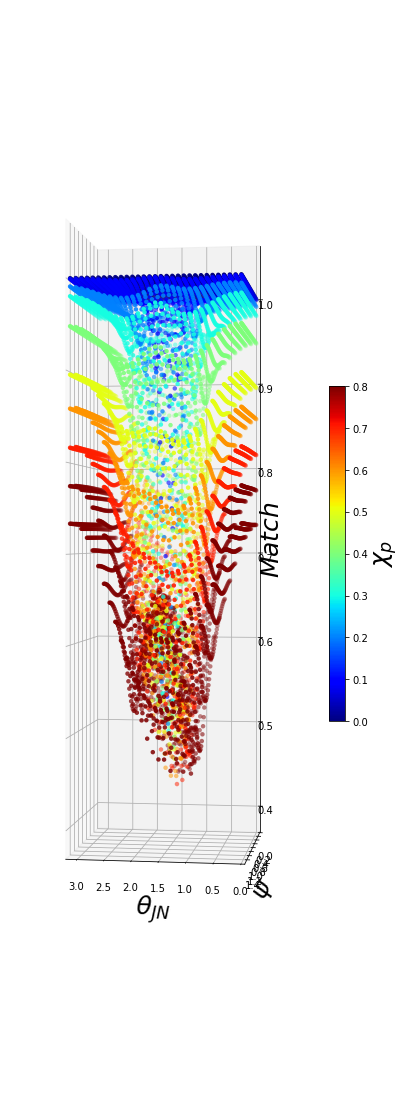

In [27]:
'''Set title and filename'''
name = "Match3D_LargeMass.png"
title1 = "$\mathcal{M}$ vs $\phi_{JL}$ vs $\\theta_{JN}$ vs $\psi$ : Masses=$20,5$ , $\chi_p=0.4$ and $\phi_{ref}=90deg$"

'''Set figure size'''
figsize = [6,20]

'''Set dot size'''
dotsize = 20

'''3D Plot: phiJL vs thetaJN vs psi vs Match'''
fig1  = py.figure(figsize=figsize)
ax    = py.axes(projection="3d")
plot1 = ax.scatter(thetaJN_plot3D,psi_plot3D,match_3D,c=chip_plot3D.flatten(),vmin=0.,vmax=0.8,s=dotsize,cmap='jet',edgecolor="none")

ax.set_xlabel("$\\theta_{JN}$", fontsize = 25)
ax.set_ylabel("$\psi$", fontsize = 25)
ax.set_zlabel("${Match}$", fontsize = 25)

bit = 0.001   
bigbit = 0.05
ax.set_xlim(thetaJN_min-bit,thetaJN_max+bit)
ax.set_ylim(psi_min-bit,psi_max+bit)
ax.set_zlim(match_3D.min()-bigbit,match_3D.max()+bigbit)

colbar = fig1.colorbar(plot1,fraction=0.05, pad=0.04)
colbar.set_label("$\chi_p$", fontsize=25)

ax.view_init(elev=0, azim=98)

#py.title(title1,fontsize=20)
#py.savefig(name)

print "Lowest match: ", match_3D.min()

So we can see that, face-on ($\sin\theta_{JN}=1$), the Match drops pretty much linearly with $\chi_p$, independent from $\psi$, for all $\chi_p\geq0.3$. At lower $\chi_p$ the relation is also approximately linear, but not as steep.

We can also see that the minima for all planes in $\chi_p$ is found at approximately $\theta_{JN}=90$ and reaches a similar Match value $(Match\sim0.45±0.05)$. This place is quite congested with points. The graph below helps make the trend easier to see - the colour axis and z-axis have been switched, so the colour now indicates $Match$ and z-axis indicates $\chi_p$.

Masses:  20.0 ,  5.0
phiRef:  0.0
Lowest match:  0.43318682043778206


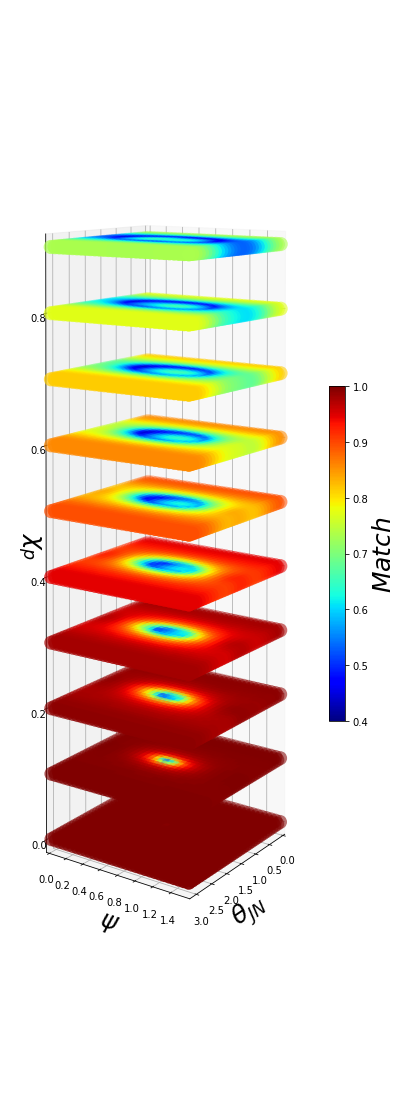

In [11]:
'''Set title and filename'''
name = "Match3D_LargeMass.png"
title1 = "$\mathcal{M}$ vs $\phi_{JL}$ vs $\\theta_{JN}$ vs $\psi$ : Masses=$20,5$ , $\chi_p=0.4$ and $\phi_{ref}=90deg$"

'''Set figure size'''
figsize = [6,20]

'''Set dot size'''
dotsize = 200

'''3D Plot: phiJL vs thetaJN vs psi vs Match'''
fig1  = py.figure(figsize=figsize)
ax    = py.axes(projection="3d")
plot1 = ax.scatter(thetaJN_plot3D,psi_plot3D,chip_plot3D,c=match_3D.flatten(),vmin=0.4,vmax=1.,s=dotsize,cmap='jet',edgecolor="none")

ax.set_xlabel("$\\theta_{JN}$", fontsize = 25)
ax.set_ylabel("$\psi$", fontsize = 25)
ax.set_zlabel("$\chi_p$", fontsize = 25)

bit = 0.001   
bigbit = 0.05
ax.set_xlim(thetaJN_min-bit,thetaJN_max+bit)
ax.set_ylim(psi_min-bit,psi_max+bit)
ax.set_zlim(chipmin-bit,chipmax+bit)

colbar = fig1.colorbar(plot1,fraction=0.05, pad=0.04)
colbar.set_label("$Match$", fontsize=25)

ax.view_init(elev=4, azim=35)

#py.title(title1,fontsize=20)
#py.savefig(name)

print "Masses: ", mass1, ", ", mass2
print "Lowest match: ", match_3D.min()

In [2]:
'''Describe relationship found in "Empirically modelling observable precession" notebook to add to/improve first term.'''

'Using relationship found in "Empirically modelling observable precession" notebook to add to/improve first term.'

We now note that the centre of the ring of worst Matches can be described using the following equation (derived/defended in my thesis, available for free in all good Cardiff University Intranets everywhere):

$(\theta_{JN},\psi)_{cen} = (90, \beta \cos\phi_{JL} + 45)$    (in degrees)

If we approximate the ring as a circle for all values of $\phi_{JL}$, which isn't entirely accurate for all cases (especially for high $\chi_p$), but isn't terribly far either, we can describe the location of the worst Matches as a circle about the centre of the ring. This circle is defined as:

$( (\theta_{JN} - \theta_{JNcen})^2 + (\psi - \psi_{cen})^2)^{1/2} - \beta = 0$

i.e.

$\big( (\theta_{JN} - 90)^2 + (\psi - \beta\cos\phi_{JL}-45)^2 \big)^{1/2} - \beta = 0$

[Once we have a half-decent function, we could attempt to work in the ellipsicity of the ring when $\phi_{JL}\neq(0,90,180,270)$. The magnitude of the ellipsicity is clearly sinusoidal over $\phi_{JL}$, with a maximum magnitude related to $\chi_p$. The orientation of the ellipse - where the circle is squeezed and where it is stretched is the tough bit to visualise and model. But that's a problem for someone else.]

So we have a function to identify where the worst Matches are (the circle of badness), and we have a term for the function which gives us an underlying base of Matches for the whole plane. We can see that, generally, the Matches radially slope downward towards the circle of badness (the Matches on the inside doing the same when the circle is large enough, with a hill in the middle).

If we find a radial function which has the right shape to fit one plane of fixed $\chi_p$ and $\phi_{JL}$ to add to the first term(s), it'll be easy enough to use python's maximisation function to make that function fit well for that plane of Matches. My strategy was to carry out the same routine for other planes, compare the coefficients the maximisation function spits out and find a trend. If there is no clear trend, this method won't work. But finding a trend means I can produce a general radial function, which completes the formula for the parameter space of $[\chi_p,\theta_{JN},\phi_{JL},\psi]$.

[If there is no clear trend in the coefficients across the planes, I imagine you could get a good-fitting model for all four parameters if you save Matches from loads of planes and use the maximisation function for all of them at once (you'd have to add extra coefficients for the trends between planes). This would need, say, ten planes for different $\phi_{JL}$ and ten planes for each of those planes for different $\chi_p$. 100 planes each with roughly 400 Matches $\sim$40,000 Matches. Easy enough to store, but that's a lot of computation time for a notebook - one plane for my mac takes 5-10 seconds, so I'd be making my mac work pretty hard for over an hour. Since you wouldn't be storing the waveforms, RAM shouldn't be an issue, but that may depend on how much memory jupyter is permitted by the OS. If you get this to work, it takes out the by-eye element of comparing the coefficients for the function in different planes, which may give a more accurate correlation.]

## Section 2: Trends in Match for Varying Mass Ratio (TM=25)

Reducing or increasing mass ratio respectively decreases and increases the effects of precession. Run the code for the first graph in Section 1 with different mass ratios to see this. I've found that there's a strong correlation in the Matches across the whole $[\theta_{JN},\psi,\phi_{JL}]$ parameter volume for any two runs where $\chi_{p1} \cdot q_1 = \chi_{p2} \cdot q_2$.

Thus if we define $Q_p$:

$Q_p = \chi_p \cdot q$

then I claim:

$\mathcal{M}(Q_p) \approx \mathrm{const.}$

for all orientations, and total mass $M=25M_{\bigodot}$. Feel free to test this for different total masses.

An example is given below, where I plot $\Delta \mathcal{M} = \mathcal{M}(Q_{p1})-\mathcal{M}(Q_{p2})$ on the colour axis.

In [7]:
'''USER INPUT'''

'''First run'''
mass1a = 20.
mass2a =  5.
chi_perp1a = 0.6
chi_perp2a = 0.

'''Second Run'''
mass1b = 18.75
mass2b =  6.25
chi_perp1b = 0.8
chi_perp2b = 0.

print "Check Q_p is constant:"
print "Q_p1 = ", mass1a/mass2a*chi_perp1a
print "Q_p2 = ", mass1b/mass2b*chi_perp1b
print "Caution: This check only works when the larger mass has all precessing spin."

Check Q_p is constant:
Q_p1 =  2.4
Q_p2 =  2.4
Caution: This check only works when the larger mass has all precessing spin.


In [8]:
'''Circle of Badness Plot: Match Calculation'''
mass1 = mass1a
mass2 = mass2a

if mass2>mass1:     #Mass1 is always bigger. Obey the law.
    tmpmass = mass2
    mass2 = mass1
    mass1 = tmpmass

'''Aligned dimensionless spin for each mass'''
'''(-1 to 1)'''
spin_z1 =  0.            #Spin components aligned with L.
spin_z2 =  spin_z1  #I tend to give both the same aligned spin - it makes controlling chi_eff easier.

'''Precessional spin magnitude for each mass'''
'''(0 to 1)'''
chi_perp1   = chi_perp1a      #DON'T EXCEED MAXIMUM SPIN OR BAD THINGS WILL HAPPEN TO YOU.
chi_perp2   = chi_perp1b     #<<< This one is only interesting if the masses are near identical and you're really bored.

'''Give ranges of psi and thetaJN (degrees)'''
psirange = 21      #Number of different psi values to be matched.
psi_min  =  0     #degrees
psi_max  = 90    #degrees

JNrange     =  41    #Number of different thetaJN values to be matched.
thetaJN_min =   0   #degrees
thetaJN_max = 180  #degrees

'''Give orientation angles (degrees)'''
phi12     =   0.     #phi12 = azimuthal angle between spins.
    #Remember the circle is only central when phiJL is 90, or 270. 
phi_JL    =  90.    #phi_JL = phase of precession of L around J.
phase     =   0.   #Reference phase = PhiRef in SimInspiralTransformPrecessingNewInitialConditions()

'''Give sky location (zero = above detector)'''
latitude  = 0.
longitude = 0.

'''Give distance to source in Mpc'''
dist = 410.

'''Reference frequency, low frequency cut-off and sample rate'''
f_ref   = 30.     #Reference frequency
low_f   = 30.      #Starting frequency
delta_t = 1./2048    #Sample rate


''' [No user input required] '''
''' ------------------------ '''

'''Convert angles to radians'''
psi_min     = radians( psi_min )
psi_max     = radians( psi_max )
thetaJN_min = radians( thetaJN_min )
thetaJN_max = radians( thetaJN_max )
phi12     = radians( phi12 )
phi_JL    = radians( phi_JL )
phase = radians( phase )

'''Create array of polarisations and thetaJNs'''
psi      = linspace(psi_min, psi_max, psirange)
theta_JN = linspace(thetaJN_min, thetaJN_max, JNrange)

'''Define spin magnitudes and inclinations'''
chi1     = sqrt(spin_z1**2 + chi_perp1**2)   #Calculate spin magnitude for each mass.
chi2     = sqrt(spin_z2**2 + chi_perp2**2)
if chi1>1:
    chi1=1.0                        #Prevent Kerr limit being exceeded
    print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."
if chi2>1:
    chi2=1.0
    print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."

if chi1 == 0.: chi1 = 10e-10               #Prevent division by zero.
if chi2 == 0.: chi2 = 10e-10
if spin_z1<0: theta1z = pi               #Gives non-precessing waveform appropriate spin polar angles.
else: theta1z = 0
if spin_z2<0: theta2z = pi
else: theta2z = 0
theta1  = arccos(spin_z1/chi1)       #Calculate polar angle for each mass.
theta2  = arccos(spin_z2/chi2)

matches1 = zeros((psirange,JNrange))


'''Set plotting arrays'''
psirangej = complex(0,psirange)
JNrangej  = complex(0,JNrange)
psi_plot,thetajn_plot = mgrid[0:psi_max:psirangej,0:thetaJN_max:JNrangej]

'''CREATE TEMPLATE'''

delta_t = 1./2048

np_inc, np_s1x, np_s1y, np_s1z, np_s2x, np_s2y, np_s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               0., #theta_JN
                                                               phi_JL, #phi_JL
                                                               theta1z, #theta1
                                                               theta2z, #theta2
                                                               phi12, #phi12
                                                               abs(spin_z1), #chi1
                                                               abs(spin_z2), #chi2
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
temp_hplus, temp_hcross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = np_inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = np_s1x,
                        spin1y = np_s1y,
                        spin1z = np_s1z,
                        spin2x = np_s2x,
                        spin2y = np_s2y,
                        spin2z = np_s2z,
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t,
                        f_ref=f_ref)

'''Set psi=0 for this one - it doesnt make a difference anyway'''
temp_vec = my_generate_detector_strain(temp_hplus,temp_hcross, 0, latitude, longitude)
delta_f = 1./ len(temp_vec) / delta_t



'''CREATE SIGNALS AND MATCH TO TEMPLATE'''


for i in range(psirange):  
    for j in range(JNrange):
        #for k in range(JLrange):
            #for l in range(chiprange):
                #for m in range(effrange):
        inc,s1x,s1y,s1z,s2x,s2y,s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               theta_JN[j],
                                                               phi_JL,
                                                               theta1,
                                                               theta2,
                                                               phi12,
                                                               chi1,
                                                               chi2,
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
        splus, scross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = s1x,
                        spin1y = s1y,
                        spin1z = s1z,
                        spin2x = s2x,
                        spin2y = s2y,
                        spin2z = s2z,
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t,
                        f_ref=f_ref)
        
        sig_vec = my_generate_detector_strain(splus,scross, psi[i],latitude,longitude)
        sig_vec.resize(len(temp_vec))
        PSD = aLIGOZeroDetHighPower(len(temp_vec),delta_f,low_f)
        
        matches1[i][j], residuals = match(temp_vec,sig_vec,psd=PSD,low_frequency_cutoff=low_f)

        
'''Second run masses'''
mass1 = mass1b
mass2 = mass2b

if mass2>mass1:     #Mass1 is always bigger. Obey the law.
    tmpmass = mass2
    mass2 = mass1
    mass1 = tmpmass

'''Precessional spin magnitude for each mass'''
'''(0 to 1)'''
chi_perp1   = chi_perp1b      #DON'T EXCEED MAXIMUM SPIN OR BAD THINGS WILL HAPPEN TO YOU.
chi_perp2   = chi_perp2b     #<<< This one is only interesting if the masses are near identical and you're really bored.


''' [No user input required] '''
''' ------------------------ '''

'''Define spin magnitudes and inclinations'''
chi1     = sqrt(spin_z1**2 + chi_perp1**2)   #Calculate spin magnitude for each mass.
chi2     = sqrt(spin_z2**2 + chi_perp2**2)
if chi1>1:
    chi1=1.0                        #Prevent Kerr limit being exceeded
    print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."
if chi2>1:
    chi2=1.0
    print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."

if chi1 == 0.: chi1 = 10e-10               #Prevent division by zero.
if chi2 == 0.: chi2 = 10e-10
if spin_z1<0: theta1z = pi               #Gives non-precessing waveform appropriate spin polar angles.
else: theta1z = 0
if spin_z2<0: theta2z = pi
else: theta2z = 0
theta1  = arccos(spin_z1/chi1)       #Calculate polar angle for each mass.
theta2  = arccos(spin_z2/chi2)

'''Calculate chi_eff and chi_p'''
A1 = 1 + 3*mass2/(4*mass1)
A2 = 1 + 3*mass1/(4*mass2)
chi_eff = ( mass1*spin_z1 + mass2*spin_z2 )/(mass1+mass2)

#See Schmidt, Ohme & Hannam (2014): "Towards models of gravitational waves..."
q = mass1/mass2
A1 = 2. + 3.*q/2
A2 = 2. + 3./(2*q)
S1 = chi_perp1*mass1**2
S2 = chi_perp2*mass2**2
top = max(A2*S1,A1*S2)
chi_p = top/(A2*mass1**2)

'''Calculate opening angle'''#                <--------------- Calculate opening angle
lalbeta2, halfbeta, s2 = LALbeta(mass1,mass2,chi_p,spin_z1,spin_z2,low_f)

matches2 = zeros((psirange,JNrange))


'''CREATE TEMPLATE'''

delta_t = 1./2048

np_inc, np_s1x, np_s1y, np_s1z, np_s2x, np_s2y, np_s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               0., #theta_JN
                                                               phi_JL, #phi_JL
                                                               theta1z, #theta1
                                                               theta2z, #theta2
                                                               phi12, #phi12
                                                               abs(spin_z1), #chi1
                                                               abs(spin_z2), #chi2
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
temp_hplus, temp_hcross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = np_inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = np_s1x,
                        spin1y = np_s1y,
                        spin1z = np_s1z,
                        spin2x = np_s2x,
                        spin2y = np_s2y,
                        spin2z = np_s2z,
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t,
                        f_ref=f_ref)

'''Set psi=0 for this one - it doesnt make a difference anyway'''
temp_vec = my_generate_detector_strain(temp_hplus,temp_hcross, 0, latitude, longitude)
delta_f = 1./ len(temp_vec) / delta_t



'''CREATE SIGNALS AND MATCH TO TEMPLATE'''


for i in range(psirange):  
    for j in range(JNrange):
        #for k in range(JLrange):
            #for l in range(chiprange):
                #for m in range(effrange):
        inc,s1x,s1y,s1z,s2x,s2y,s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               theta_JN[j],
                                                               phi_JL,
                                                               theta1,
                                                               theta2,
                                                               phi12,
                                                               chi1,
                                                               chi2,
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
        splus, scross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = s1x,
                        spin1y = s1y,
                        spin1z = s1z,
                        spin2x = s2x,
                        spin2y = s2y,
                        spin2z = s2z,
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t,
                        f_ref=f_ref)
        
        sig_vec = my_generate_detector_strain(splus,scross, psi[i],latitude,longitude)
        sig_vec.resize(len(temp_vec))
        PSD = aLIGOZeroDetHighPower(len(temp_vec),delta_f,low_f)
        
        matches2[i][j], residuals = match(temp_vec,sig_vec,psd=PSD,low_frequency_cutoff=low_f)

matchdiff = matches1-matches2

q1 =  1.06666666667
chi_p1 =  0.6
q2 =  0.8
chi_p2 =  0.8
phi_JL =  90.0


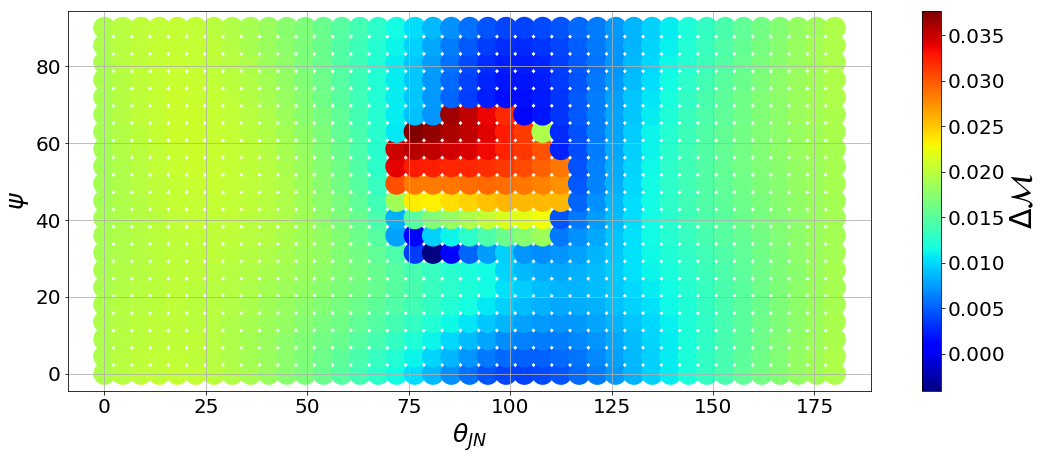

In [9]:
'''Print parameters'''
print "q1 = ", mass1a/mass1b
print "chi_p1 = ", chi_perp1a
print "q2 = ", mass2a/mass2b
print "chi_p2 = ", chi_perp1b
print "phi_JL = ", degrees(phi_JL)
'''Choose figure size (scalar) and dot size'''
figsize=[18,7]
dotsize=500

'''Plot Match vs thetaJN vs chi_p'''
py.figure(figsize=figsize)
py.xlabel("$\\theta_{JN}$",fontsize=25)
py.ylabel("$\psi$",fontsize=25)
py.scatter(degrees(thetajn_plot), degrees(psi_plot), c=matchdiff, s=dotsize, cmap = 'jet', edgecolor='none')
    #Alternatively, max and min colour defined by the matches:
#py.scatter(degrees(thetajn_plot), degrees(psi_plot), c=match2, vmin=match2.min(), vmax=match2.max(), s=dotsize, cmap = 'jet', edgecolor='none')
cbar = py.colorbar()

'''Add contour lines'''
#lines = [0.5,0.6,0.7,0.8,0.9,0.97] #Leave empty brackets [] for no lines.
#Cont = py.plt.contour(degrees(thetajn_plot), degrees(psi_plot), matches, lines, linewidth=30, cmap = 'Reds')
#py.plt.clabel(Cont, inline=1, fontsize=15)

py.grid(which='both')
cbar.set_label(label="$\Delta\mathcal{M}$",size=30)
cbar.ax.tick_params(labelsize=20)
py.tick_params(axis='both', which='both', labelsize=20)

#py.savefig(name)
py.show()

## A More rigorous proof...

That was just the difference in Matches between two runs, for one value of $Q_p$. To show the relation works more generally, I calculate the variance $\mathrm{var}(\mathcal{M})$ through $\chi_p$ for constant $Q_p$, for each point in the $[\theta_{JN},\psi]$ plane.

In [27]:
'''Give Qp and the source masses (in solar masses)'''

Qp =   3.6 #chi_p times q
TM  = 25.  #total mass

'''Aligned dimensionless spin for each mass'''
'''(-1 to 1)'''
spin_z1 =  0.0            #Spin components aligned with L.
spin_z2 =  spin_z1  #I tend to give both the same aligned spin - it makes controlling chi_eff easier.

'''Give number of points in chi_p from which variance is calculated.'''
chiprange = 16

'''Give ranges of psi and thetaJN (degrees)'''
psirange = 16      #Number of different psi values to be matched.
psi_min  =  0.     #degrees
psi_max  = 90.    #degrees

JNrange     =  31    #Number of different thetaJN values to be matched.
thetaJN_min =   0.   #degrees
thetaJN_max = 180.  #degrees

'''Give orientation angles (degrees)'''
phi12     =   0.     #phi12 = azimuthal angle between spins.
    #Remember the circle is only central when phiJL is 90, or 270. 
phi_JL    =  90.    #phi_JL = phase of precession of L around J.
phase     =   0.   #Reference phase = PhiRef in SimInspiralTransformPrecessingNewInitialConditions()

'''Give sky location (zero = above detector)'''
latitude  = 0.
longitude = 0.

'''Give distance to source in Mpc'''
dist = 410.

'''Give sample rate and frequency limits'''
low_f   = 30.      #Starting frequency
delta_t = 1./2048    #Sample rate




''' [No user input required beyond this point] '''
''' ------------------------------------------ '''

'''Maximum range of chi_p'''
chipmin   = Qp/12.   #Lowest chi_p value which allows Qp to be reached within BBH calibration zone of PhenomPv2 (q<12).    
chipmax   = 1.-spin_z1**2

'''Convert angles to radians'''
psi_min     = radians( psi_min )
psi_max     = radians( psi_max )
thetaJN_min = radians( thetaJN_min )
thetaJN_max = radians( thetaJN_max )
phi12     = radians( phi12 )
phi_JL    = radians( phi_JL )
phase = radians( phase )

'''Create array of polarisations, thetaJNs and chi_p'''
psi      = linspace(psi_min, psi_max, psirange)
theta_JN = linspace(thetaJN_min, thetaJN_max, JNrange)
chi_p = linspace(chipmin, chipmax, chiprange)

'''Define non-precessing spin coords'''
if spin_z1<0: theta1z = pi               #Gives non-precessing waveform appropriate spin polar angles.
else: theta1z = 0
if spin_z2<0: theta2z = pi
else: theta2z = 0

'''Match array'''
match_3D = zeros((psirange,JNrange,chiprange))

'''Set plotting arrays'''
varrangej = complex(0,chiprange)
psirangej = complex(0,psirange)
JNrangej  = complex(0,JNrange)

delta_t = 1./2048

'''Off we go'''
for k in range(chiprange):
    
    '''Masses'''
    q = Qp/chi_p[k]
    mass2 = TM/(1+q)
    mass1 = TM - mass2
    
    '''Define spin magnitudes and inclinations'''
    chi1     = sqrt(spin_z1**2 + chi_p[k]**2)   #Calculate spin magnitude for each mass.
    chi2     = sqrt(spin_z2**2 + 0.) #only larger mass has precessing spin.
    if chi1>1:
        chi1=1.0                        #Prevent Kerr limit being exceeded
        print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."
    if chi2>1:
        chi2=1.0
        print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."

    if chi1 == 0.: chi1 = 10e-10               #Prevent division by zero in arccos.
    if chi2 == 0.: chi2 = 10e-10
    theta1  = arccos(spin_z1/chi1)         #Calculate polar angle for each mass.
    theta2  = arccos(spin_z2/chi2)

    '''Create template.'''
    np_inc, np_s1x, np_s1y, np_s1z, np_s2x, np_s2y, np_s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               0., #theta_JN
                                                               phi_JL, #phi_JL
                                                               theta1z, #theta1
                                                               theta2z, #theta2
                                                               phi12, #phi12
                                                               abs(spin_z1), #chi1
                                                               abs(spin_z2), #chi2
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
    temp_hplus, temp_hcross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = np_inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = np_s1x,
                        spin1y = np_s1y,
                        spin1z = np_s1z,
                        spin2x = np_s2x,
                        spin2y = np_s2y,
                        spin2z = np_s2z,
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t)

    '''Set psi=0 for this one - it doesnt make a difference anyway'''
    temp_vec = my_generate_detector_strain(temp_hplus, temp_hcross, 0, latitude, longitude)
    delta_f = 1./ len(temp_vec) / delta_t
    
    
    for i in range(psirange):    
        for j in range(JNrange):
            inc,s1x,s1y,s1z,s2x,s2y,s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               theta_JN[j],
                                                               phi_JL,
                                                               theta1,
                                                               theta2,
                                                               phi12,
                                                               chi1,
                                                               chi2,
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
            splus, scross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = s1x,
                        spin1y = s1y,
                        spin1z = s1z,
                        spin2x = s2x,
                        spin2y = s2y,
                        spin2z = s2z,
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t)
        
            sig_vec = my_generate_detector_strain(splus,scross, psi[i], latitude,longitude)
            sig_vec.resize(len(temp_vec))
            PSD = aLIGOZeroDetHighPower(len(temp_vec),delta_f,low_f)
            match_3D[i][j][k], residuals = match(temp_vec,sig_vec,psd=PSD,low_frequency_cutoff=low_f)

psi_plot,thetajn_plot = mgrid[0:psi_max:psirangej,0:thetaJN_max:JNrangej]
match_var = zeros((psirange,JNrange))
for i in range(psirange):
    for j in range(JNrange):
        match_var[i][j] = var(match_3D[i][j][:],ddof=1)

print "Mean var: ", match_var.mean()
above1 = match_var[match_var>0.01]
print "Fraction of variances above 0.01: ", above1.size*1.0/match_var.size

Mean var:  0.0006328835217808473
Fraction of variances above 0.01:  0.0


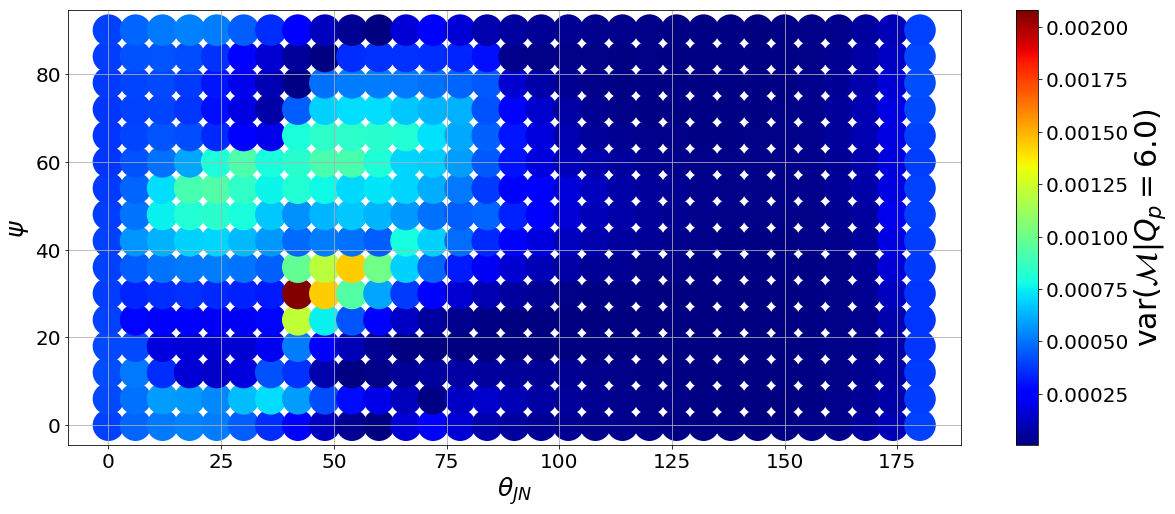

In [33]:
'''Name .png file'''
#name = "Qp48_Chieff-4_TM25"
clabel = "$\mathrm{var}(\mathcal{M}|Q_p=$"+str(Qp)+")"

'''Choose figure size (scalar) and dot size'''
figsize=[20,8]
dotsize=1000

'''Plot Match vs thetaJN vs chi_p'''
py.figure(figsize=figsize)
py.xlabel("$\\theta_{JN}$",fontsize=25)
py.ylabel("$\psi$",fontsize=25)
py.scatter(degrees(thetajn_plot), degrees(psi_plot), c=match_var, s=dotsize, cmap = 'jet', edgecolor='none')
    #Alternatively, max and min colour defined by the matches:
    #py.scatter(degrees(thetajn_plot), degrees(psi_plot), c=match2, vmin=match2.min(), vmax=match2.max(), s=dotsize, cmap = 'jet', edgecolor='none')
cbar = py.colorbar()

py.grid(which='both')
cbar.set_label(label=clabel,size=30)
cbar.ax.tick_params(labelsize=20)
py.tick_params(axis='both', which='both', labelsize=20)

#py.savefig(name)
py.show()

Change $Q_p$, change the angles, change total mass - it always gives variances which mostly, if not entirely, stay below 0.01 across the plane. This is not the case when $\chi_{eff}\neq0$.

The plots below show the relationship between $Q_p$ and $\beta$.

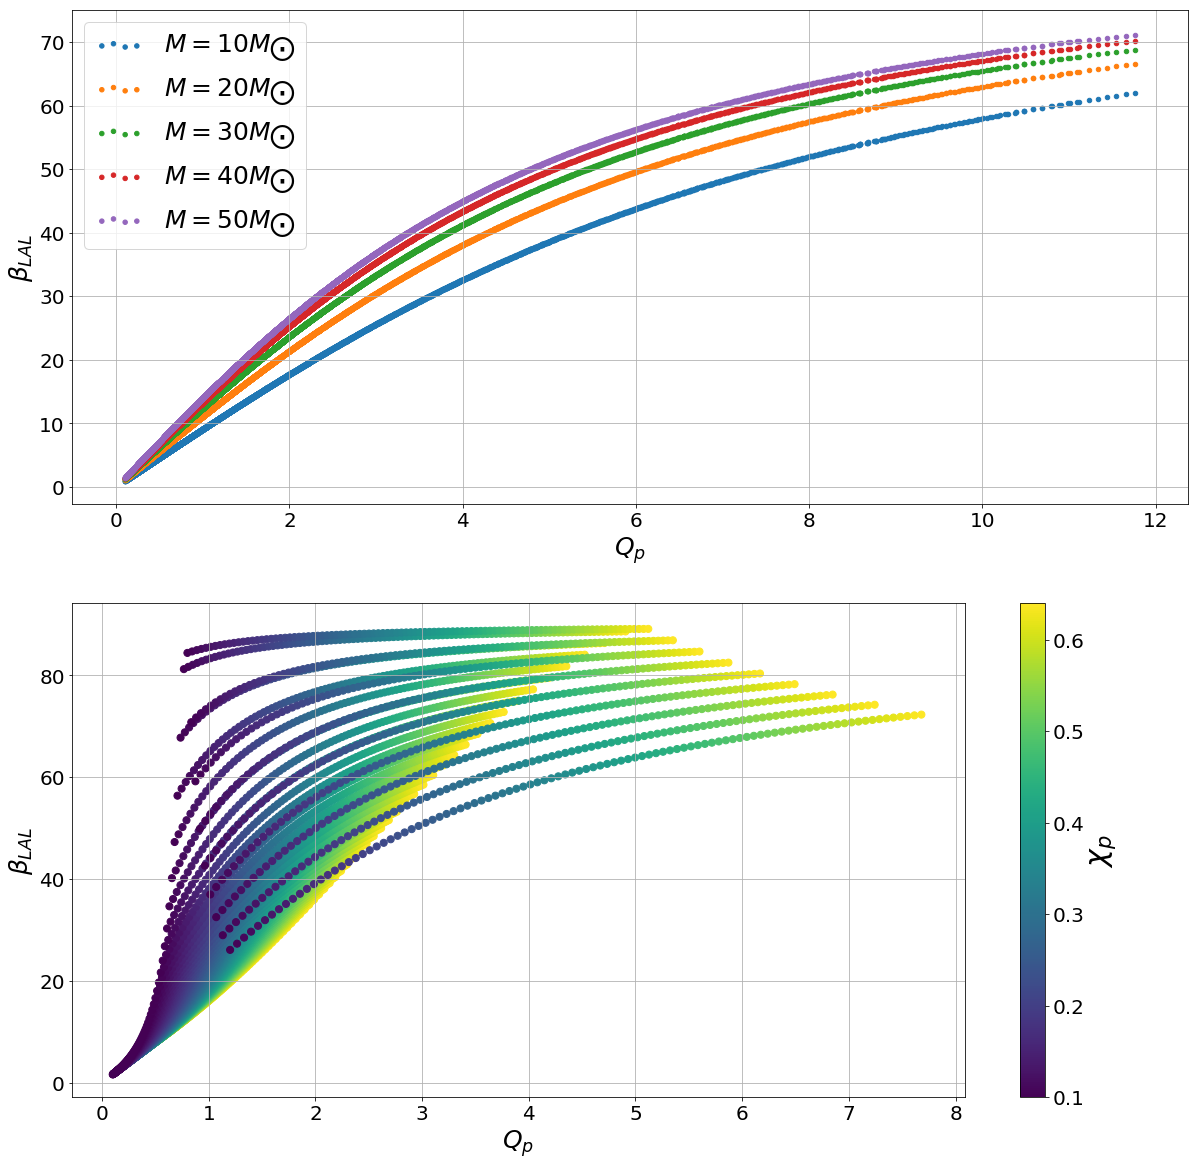

In [34]:
'''Code for plotting a graph of Qp vs Beta'''

Mlines = 5        #Number of values of total mass for which you want a curve.
MassInterval = 10 #Interval between each total mass
chi_p = linspace(0.1,0.98,100)

betas = zeros((100,100,Mlines))
Qps   = zeros((100,100,Mlines))

for k in range(Mlines):
    TM = MassInterval*(k+1)
    chieff= -.0
    mass1 = linspace(TM/2.,TM*12./13.,100)   #TM/2 ensures q>1. TM*12/13 ensures maximum q<12.
    mass2 = TM - mass1
    qs = mass1/mass2
    for i in  range(100):
        betas[i,:,k], c, c = LALbeta(mass1[i],mass2[i],chi_p,chieff,chieff,30.)
        Qps[i,:,k] = mass1[i]/mass2[i] * chi_p


        
        
figsize=[20,20]
dotsize=50

'''Plot Match vs thetaJN vs chi_p'''
py.figure(figsize=figsize)
py.subplot(2,1,1)
py.ylabel("$\\beta_{LAL}$",fontsize=25)
py.xlabel("$Q_p$",fontsize=25)
for k in range(Mlines):
    label = "$M=$"+str(MassInterval*(k+1))+"$M_{\\bigodot}$"
    py.scatter(Qps[:,:,k].flatten(),degrees(betas[:,:,k].flatten()),s=20,label=label)
py.tick_params(axis='both', which='both', labelsize=20)
py.grid(which='both')
py.legend(loc="upper left",scatterpoints=4,fontsize=25)
#cbar = py.colorbar()
#cbar.set_label(label="$\chi_p$",size=30)
#cbar.ax.tick_params(labelsize=20)



'''Plot2: chi_eff'''
TM = 25.
chieff= -0.6

chipmax = 1.-chieff**2
chi_p = linspace(0.1,chipmax,100)
betas = zeros((100,100))
Qps   = zeros((100,100))

mass1 = linspace(TM/2.,TM*12./13.,100)   #TM/2 ensures q>1. TM*12/13 ensures maximum q<12.
mass2 = TM - mass1
qs = mass1/mass2
for i in  range(100):
    betas[i,:], c, c = LALbeta(mass1[i],mass2[i],chi_p,chieff,chieff,30.)
    Qps[i,:] = mass1[i]/mass2[i] * chi_p

'''Plot Match vs thetaJN vs q'''
py.subplot(2,1,2)
py.ylabel("$\\beta_{LAL}$",fontsize=25)
py.xlabel("$Q_p$",fontsize=25)
for i in range(100):
    py.scatter(Qps[i,:],degrees(betas[i,:]), c=chi_p, s=dotsize)
py.tick_params(axis='both', which='both', labelsize=20)
py.grid(which='both')
cbar = py.colorbar()
cbar.set_label(label="$\chi_p$",size=30)
cbar.ax.tick_params(labelsize=20)

py.savefig("QpVsBeta2")


 See how the relationship is pretty much perfectly defined for constant total mass. Compare that to $\chi_{eff}\neq0$, which ruins the one-to-one relationship. This means:
 
- It is possible to adapt $Q_p$ to trace lines of constant Match through total mass as well as $\chi_p$ and $q$.
- It would be much more difficult, if not impossible, to adapt $Q_p$ to trace lines of constant Match through $\chi_{eff}$ effectively.

The latter would require a function to be found which, when added to $Q_p$, flattens the $Q_p$ vs $\beta$ relationship we currently see for non-zero $\chi_{eff}$ into a one-to-one curve. Since the relationship changes dependent on the value of $\chi_{eff}$, some further insight will be needed to understand what this function may look like.